In [1]:
from fastai.vision.all import *

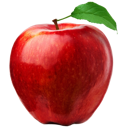

In [2]:
im = Image.open('../input/fruit-images-for-object-detection/train_zip/train/apple_1.jpg')
im.to_thumb(128, 128)

In [3]:
fms = get_image_files('../input/fruit-images-for-object-detection/train_zip/train/')

In [4]:
fms

(#240) [Path('../input/fruit-images-for-object-detection/train_zip/train/banana_68.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/apple_46.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/orange_20.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/mixed_1.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/apple_68.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/banana_31.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/orange_28.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/apple_38.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/apple_62.jpg'),Path('../input/fruit-images-for-object-detection/train_zip/train/apple_21.jpg')...]

`verify_images` is used to validate the images aren't correct

In [5]:
verify_images

<function fastai.vision.utils.verify_images(fns)>

In [6]:
failed = verify_images(fms)
failed

(#0) []

Have to tell fastai the data you have and how it's structured.

Used a factory method in Lesson 1. Now using a more flexible way to use data in whatever format you want.

## 01:21:46 - Datablock API

* blocks - tell Fast.ai what your dependant and independant variables are.
* get_items - how do you get a file of all the file names?
* splitter - how do you split the data into validation and training set?
* get_y - how do you get the labels for each train image?
* item_tfms - what transforms should be run on each image?

Order of functions as follows:

1. get_items
2. get_x, get_y (no get_x in this example)
3. blocks[0].create, blocks[1].create
4. item_tfms
5. Splitter (spins into train and val)
6. Collate (DataLoader)
7. batch_tfms - not used in example below

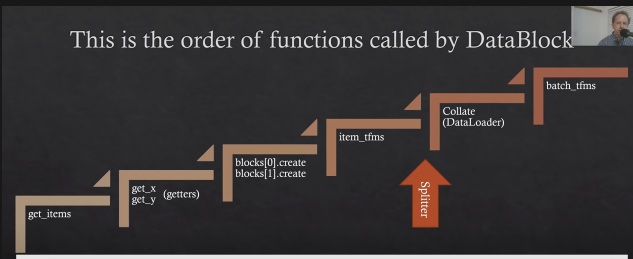

In [7]:
def label_func(label):
    """Get label from prefix of filename.
    
    apple_46.jpg -> apple
    """
    return label.name.split('_')[-2]

fruit = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=420),
    get_y=label_func,
    item_tfms=Resize(128)
)

In [8]:
path = '../input/fruit-images-for-object-detection/train_zip/train'

In [9]:
dls = fruit.dataloaders(path)

In [10]:
dls

## 01:24:58 - DataLoaders

Now have an instance of a dataloaders, which has a validation and training dataloader.

A dataloader grabs a few (batch) of items and puts them on the GPU.

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


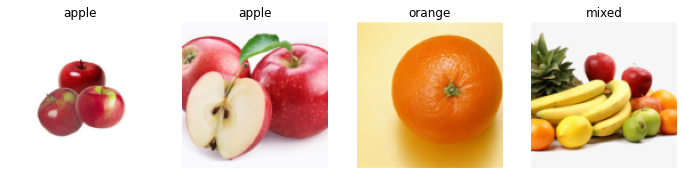

In [11]:
dls.show_batch(max_n=4, nrows=1)

In [12]:
fruit = fruit.new(
    item_tfms=RandomResizedCrop(244, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = fruit.dataloaders(path)

In [13]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.382967,3.413582,0.875000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.241950,1.563377,0.708333,00:04
1,0.947281,0.752443,0.312500,00:05
2,0.731805,0.390660,0.166667,00:04
3,0.575729,0.234377,0.104167,00:04
4,0.464878,0.185962,0.062500,00:04
5,0.386068,0.171123,0.062500,00:04
6,0.326107,0.155518,0.041667,00:04
7,0.295240,0.147135,0.020833,00:04


## 01:27:06 - Confusion matrix

* Shows you how many you predicted correctly from each class.
    * Diagonal are all correct.

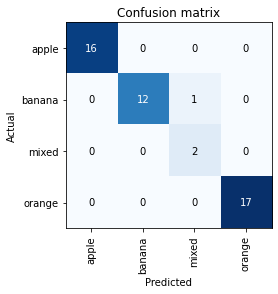

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## 01:27:42 - Plot top losses

* Show you watch you errors look like: 
  predicted/actual or the predictions model was least confident about.

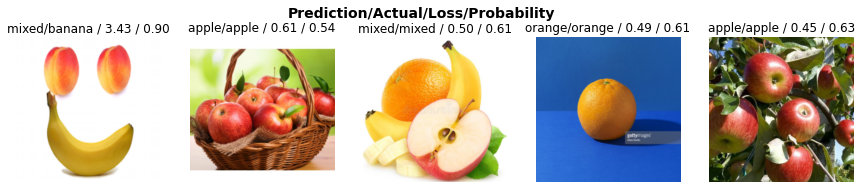

In [16]:
interp.plot_top_losses(5, nrows=1)

## 01:28:19 - Getting into production

* Need to export model
    * Create new file that contains the architecture and all params of model
* That can be copied to a server and treated as a program

In [17]:
learn.export()

In [18]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Can then load exported model with `load_learner`

In [19]:
learn_inf = load_learner(path/'export.pkl')

Then make a prediction:

In [20]:
learn_inf.predict('../input/fruit-images-for-object-detection/test_zip/test/apple_77.jpg')

('apple', tensor(0), tensor([9.9949e-01, 2.5578e-06, 4.4289e-04, 6.2133e-05]))